In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 10
macro_configs = config_generator()

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
### --- Set empirical parameters --- ###

#network properties size
#N = 8000
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
g = 2
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

In [4]:
#Set tasks

R = 2
alpha = 0.5
N_tasks = int(alpha * N)
#PR_D = params['PR_D']
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
sigma_mn_all = np.zeros((R, R, N_tasks))
#C_sigma = params['C_sigma']
total_attempts = 0
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=0.6,
                                                                                 sigma_off=0.6,
                                                                                 symmetry_factor=0,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.6, -0.4], [0.4, 0.2]])
sigma_mn_all[:,:,1] = np.array([[0.5, 0.3], [0.3, 0.5]])
sigma_mn_all[:,:,2] = np.array([[0.1, 0.9], [-0.3, 0.2]])
sigma_mn_all[:,:,3] = np.array([[-0.2, 0.2], [0.1, 0]])
sigma_mn_all[:,:,4] = np.array([[0.2, -0.2], [-0.4, -0.5]])
sigma_mn_all[:,:,5] = np.array([[-0.2, 0], [0.2, 0.9]])

2233


In [5]:
D

array([2., 2., 2., ..., 2., 2., 2.])

In [7]:
### --- variance plot --- ###

T_sim = 2000
dt = 0.05
x0 = torch.tensor(np.random.normal(0, 0.1, N)).type(torch.FloatTensor).to(0)[None,:]
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
x, r = sample_activity(T_sim=T_sim, dt_save=1, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=100, noise_series=None)
Z_hat = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r)

In [26]:
### --- variance plot 2 --- ###

T_sim = 2000
dt = 0.05
x0 = torch.tensor(np.random.normal(0, 0.1, N)).type(torch.FloatTensor).to(0)[None,:]
D_changed = D.copy()
D_changed[0] = 9
W_, all_loadings = sample_W_optimized(sigma_mn_all, D_changed, N)
x, r = sample_activity(T_sim=T_sim, dt_save=1, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=100, noise_series=None)
Z_hat_2 = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r)

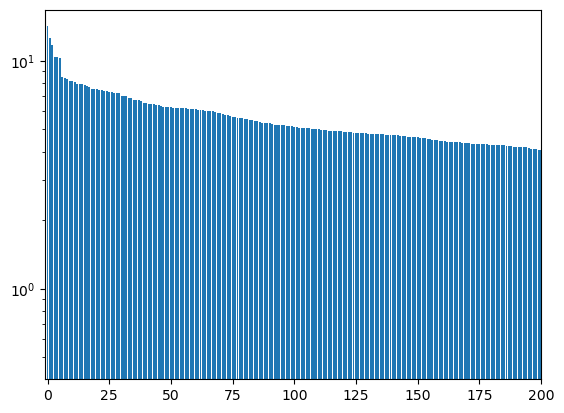

In [28]:
#plt.bar(x=np.arange(2000), height=Z_hat.var(1).sum(-1))
#plt.plot(sorted(Z_hat.var(1).sum(-1))[::-1], '.')
plt.bar(x=np.arange(2000), height=sorted(Z_hat.var(1).sum(-1))[::-1])
plt.xlim([-1, 200])
plt.yscale('log')

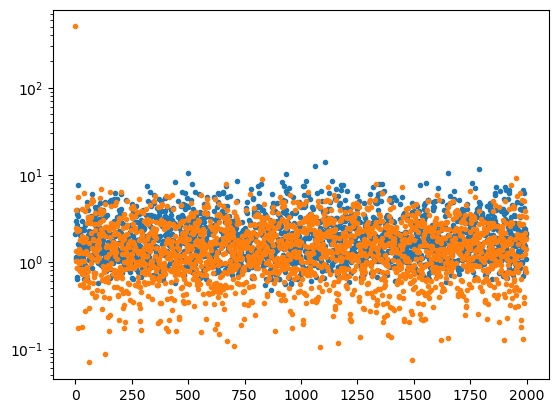

In [34]:
#plt.bar(x=np.arange(2000), height=Z_hat.var(1).sum(-1))
plt.plot(Z_hat.var(1).sum(-1), '.')
plt.plot(Z_hat_2.var(1).sum(-1), '.')
#plt.bar(x=np.arange(2000), height=sorted(Z_hat_2.var(1).sum(-1))[::-1])
#plt.xlim([-1, 200])
plt.yscale('log')

In [ ]:
Z_hat.

In [113]:
T_sim = 400
dt = 0.05
x0 = torch.tensor(np.random.normal(0, 0.1, N)).type(torch.FloatTensor).to(0)[None,:]
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_series=None)
Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]

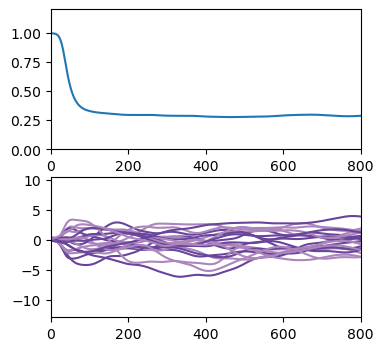

In [114]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4))
ax[0].plot(phi_prime_numpy(x).mean(1))
for i in range(10):
    ax[1].plot(Z[i,:,0], color='#68449B')
    ax[1].plot(Z[i,:,1], color='#AB85BC')
ax[0].set_ylim([0, 1.2])
for i in range(2):
    ax[i].set_xlim([0, 800])

In [115]:
np.savez('packaged_results/spontaneous_gain_ex.npz', Z=Z, phi_prime=phi_prime_numpy(x).mean(1))

In [68]:
phi_prime_numpy(x).mean(1)

array([0.992413 , 0.9930189, 0.9934295, ..., 0.2941322, 0.2942534,
       0.2943888], dtype=float32)

In [122]:
#Set tasks

R = 2
N_tasks = 2000
#PR_D = params['PR_D']
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
sigma_mn_all = np.zeros((R, R, N_tasks))
#C_sigma = params['C_sigma']
total_attempts = 0
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=0.6,
                                                                                 sigma_off=0.6,
                                                                                 symmetry_factor=0,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.6, -0.4], [0.4, 0.2]])

2234


In [123]:
D

array([2., 2., 2., ..., 2., 2., 2.])

In [90]:
D

array([2., 2., 2., ..., 2., 2., 2.])

In [117]:
T_sim = 200
dt = 0.05
D[0] = 9
x0 = torch.tensor(np.random.normal(0, 0.1, N)).type(torch.FloatTensor).to(0)[None,:]
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_series=None)
Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]

In [107]:
phi_prime_numpy(x).mean(1)

array([0.99247533, 0.993112  , 0.9935515 , ..., 0.23007824, 0.23061578,
       0.23116688], dtype=float32)

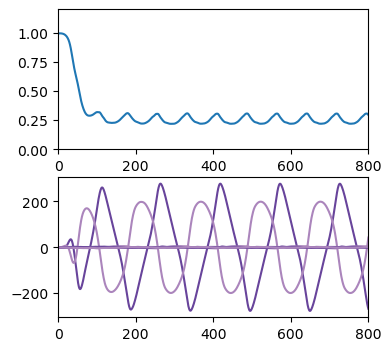

In [118]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4))
ax[0].plot(phi_prime_numpy(x).mean(1))
ax[1].plot(Z[0,:,0], color='#68449B')
ax[1].plot(Z[0,:,1], color='#AB85BC')
for i in range(1,5):
    ax[1].plot(Z[i,:,0], color='#68449B')
    ax[1].plot(Z[i,:,1], color='#AB85BC')
ax[0].set_ylim([0, 1.2])
for i in range(2):
    ax[i].set_xlim([-1, 800])

In [119]:
np.savez('packaged_results/dominant_gain_ex.npz', Z=Z, phi_prime=phi_prime_numpy(x).mean(1))

In [ ]:
N_W_samples = 40
C_emp_avg = 0
S_emp_avg = 0
z_ccov_emp_avg = 0

#lags window
dt = 0.05
T_window_emp = 120
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

for i_W_sample in range(N_W_samples):
    
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
    
    ### --- Estimate S empirically --- ###
    
    T_sim = 5000
    dt = 0.05
    n_T = int(T_sim/dt)
    noise_series = 0.05*np.random.normal(0, 1, (N, n_T))
    noise_series = noise_series[np.newaxis,:,:]
    noise_series = torch.from_numpy(noise_series).to(0)
    
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=noise_series)
    r = torch.from_numpy(r).type(torch.FloatTensor).to(0)
    #eta = torch.matmul(r, W_.T)
    eta = noise_series.squeeze().T[int(200/0.05):]
    phi_ft = uni_rfft(r.T, dt, dim=1)
    eta_ft = uni_rfft(eta.T, dt, dim=1)
    C_eta_ft = uni_corr(eta_ft, eta_ft, dt, dim=1).mean(0)
    C_phi_eta_ft = uni_corr(phi_ft, eta_ft, dt, dim=1).mean(0)
    C_eta_ft[C_eta_ft == 0] = np.nan
    S_ft = uni_conv(C_phi_eta_ft, uni_inv(C_eta_ft))
    S_ft[torch.isnan(S_ft)] = 0.0
    S = uni_irfft(S_ft, dt)
    S_emp = S.cpu().numpy()
    
    ### --- Estimate C empirically --- ###
    
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    r = torch.from_numpy(r).type(torch.FloatTensor).to(0)
    C_emp_unit = compute_lagged_xcov(r[:,None,:], r[:,None,:], lags_emp, dt_save=dt)
    C_emp = C_emp_unit.cpu().detach().numpy().squeeze().mean(-1)
    C_emp = upsample_array(C_emp, int(dT_emp/dt))
    C_emp = np.concatenate([C_emp, np.array([C_emp[-1]]), C_emp[1:][::-1]])
    lags_emp_full = np.concatenate([lags_emp, np.array([lags_emp[-1]]), -lags_emp[1:][::-1]])
    
    C_emp_avg += C_emp / N_W_samples
    S_emp_avg += S_emp[:len(C_emp)] / N_W_samples
    
    ### --- Estimate Cz1 empirically --- ###
    
    r = r.cpu().numpy()
    Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]
    Z = Z - Z.mean(axis=1, keepdims=True)
    Z_ft = np.fft.rfft(Z[:,:,:], axis=1, norm='ortho')
    z_ccov = np.fft.irfft(np.einsum('awr, aws -> awrs', Z_ft, np.conj(Z_ft)), axis=1)
    z_ccov_emp_avg += z_ccov/N_W_samples

Z_emp = np.concatenate([z_ccov_emp_avg[:,:int(T_window_emp/dt),:,:],
                        z_ccov_emp_avg[:,-int(T_window_emp/dt):,:,:]], axis=1)

In [5]:
### --- Set theory parameters --- ###
T_window = 120
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([lags, np.array([lags[-1]]), -lags[1:][::-1]])

In [ ]:
sigma_mn_all_flat = np.vstack(sigma_mn_all)
N_samples = 10000
num_iter = 400
final_avg_iter = 100
#run DMFT solver loop
C_dmft, S_dmft = util.solve_dmft(
    update_fn=(lambda C, S:
               update_extensive_tasks_general(torch.tensor(D).to(0),
                                              torch.tensor(sigma_mn_all_flat).to(0),
                                              C, S, N_samples=N_samples,
                                              dt=dT, alpha=alpha)),
    callback_fn=None,
    init_dt=dT,
    N_t=int((2*T_window)/dT),
    num_iter=num_iter,
    device=0,
    alpha=0.8,
    final_avg_iter=final_avg_iter,
    verbose=True)
#plt.xlim([0, 2000])

In [ ]:
processed_data = np.array([S_numpy, S_emp_avg, C_numpy, C_emp_avg,
                           Z_emp[0,:,0,0], Z_emp[0,:,1,1], Z_emp[0,:,1,0], Z_emp[0,:,0,1],
                           Z_emp[1,:,0,0], Z_emp[1,:,1,1], Z_emp[1,:,1,0], Z_emp[1,:,0,1],
                           Z_emp[2,:,0,0], Z_emp[2,:,1,1], Z_emp[2,:,1,0], Z_emp[2,:,0,1],
                           Z_emp[3,:,0,0], Z_emp[3,:,1,1], Z_emp[3,:,1,0], Z_emp[3,:,0,1],
                           Z_emp[4,:,0,0], Z_emp[4,:,1,1], Z_emp[4,:,1,0], Z_emp[4,:,0,1],
                           Z_emp[5,:,0,0], Z_emp[5,:,1,1], Z_emp[5,:,1,0], Z_emp[5,:,0,1]])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sigma_mn_all, 'dim_emp': None,
          'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [ ]:
###Truncate file above
file_name = 'Figure_2_Basic_Fits'
job_name = 'single_site_small_C'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

In [ ]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1,
               results_subdir='Multi_Task_Elife')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False,
           results_subdir='Multi_Task_Elife', lkumar=False)

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'single_site_sym_N8k_3'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='Multi_Task_Elife')

In [ ]:
theory_results[1].shape

In [ ]:
theory_results[0]
with open('packaged_results/fig2_theory_fits.pkl', 'wb') as f:
    pickle.dump(theory_results, f)

In [ ]:
i_sym = 0
i_seed = 2
plt.figure(figsize=(2, 2))
theory = theory_results[1][i_sym, i_seed,2,:]
sim = theory_results[1][i_sym, i_seed,3,:]
plt.plot(theory)
plt.plot(sim)
plt.xlim([0, 1500])
ymax = np.amax(np.concatenate([theory, sim]))
plt.ylim([0, ymax * 1.05])
plt.figure(figsize=(2, 2))
theory = theory_results[1][i_sym, i_seed,0,:]
sim = theory_results[1][i_sym, i_seed,1,:]
plt.plot(theory)
plt.plot(sim)
plt.xlim([0, 200])
# theory = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,0,:].mean(0)
# sim = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,1,:].mean(0)
# plt.plot(theory)
# plt.plot(sim)
# plt.xlim([0, 400])
# ymax = np.amax(np.concatenate([theory, sim]))
# ymin = np.amin(np.concatenate([theory, sim]))
# plt.ylim([ymin, ymax * 1.05])

In [ ]:
i_sym = 0
i_seed = 2
use_theory_SC = True
if use_theory_SC:
    S = torch.tensor(theory_results[1][i_sym, i_seed, 0, :], dtype=torch.float32).to(0)
    C = torch.tensor(theory_results[1][i_sym, i_seed, 2, :], dtype=torch.float32).to(0)
else:
    S = torch.tensor(theory_results[1][i_sym, i_seed, 1, :], dtype=torch.float32).to(0)
    C = torch.tensor(theory_results[1][i_sym, i_seed, 3, :], dtype=torch.float32).to(0)
N_t = C.shape[0]
#T_extra = 1000
dt = 0.05
S_ = uni_rfft(S, dt)
#S_[1000:] = 0
smoothed_S = uni_irfft(S_, dt)
C_w = uni_rfft(C, dt)

i_task = 0
#Crr = np.array([[0.8, -0.4],[0.4, 0.8]])
Crr = sigma_mn_all[:,:,i_task]
#Crr = Crr
#Crr = Crr.T
#T = len(C_phi)
#t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
#sampfreq = 1/dT
#w = 2*np.pi*sampfreq*t_indices/T
S_omega = np.sqrt(2*np.pi)*S_.cpu().numpy()[:,None,None]
M_inv = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr.T[None,:,:]*S_omega)
M_invT = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr[None,:,:]*S_omega.conj())
z_ccov = np.zeros_like(M_inv)
for w in range(z_ccov.shape[0]):
    z_ccov[w] = D[i_task]**2 * M_inv[w,:,:].dot(M_invT[w,:,:]) * C_w[w].cpu().numpy()
z_ccov_w = torch.from_numpy(z_ccov).to(0)
z_ccov_T = uni_irfft(z_ccov_w, 0.05, axis=0)
#z_ccov_T = z_ccov_T.cpu().numpy()

z_ccov_avg = theory_results[1][i_sym, i_seed,:, :].T
T = z_ccov_T.shape[0]

acov_T_11 = torch.cat([z_ccov_T[:,0,0][T//2:], z_ccov_T[:,0,0][:T//2]]).cpu().numpy()
acov_T_22 = torch.cat([z_ccov_T[:,1,1][T//2:], z_ccov_T[:,1,1][:T//2]]).cpu().numpy()
ccov_T_12 = torch.cat([z_ccov_T[:,1,0][T//2:], z_ccov_T[:,1,0][:T//2]]).cpu().numpy()
ccov_T_21 = torch.cat([z_ccov_T[:,0,1][T//2:], z_ccov_T[:,0,1][:T//2]]).cpu().numpy()
acov_avg_11 = np.concatenate([z_ccov_avg[:,4+4*i_task][-T//2:], z_ccov_avg[:,4+4*i_task][:T//2]])
acov_avg_22 = np.concatenate([z_ccov_avg[:,5+4*i_task][-T//2:], z_ccov_avg[:,5+4*i_task][:T//2]])
ccov_avg_12 = np.concatenate([z_ccov_avg[:,6+4*i_task][-T//2:], z_ccov_avg[:,6+4*i_task][:T//2]])
ccov_avg_21 = np.concatenate([z_ccov_avg[:,7+4*i_task][-T//2:], z_ccov_avg[:,7+4*i_task][:T//2]])

fig, ax = plt.subplots(2, 2)
time_vec = np.arange(-len(acov_avg_11)*dt/2, len(acov_avg_11)*dt/2, dt)
ax[0,0].plot(time_vec, acov_avg_11, color='C0')
ax[0,0].plot(time_vec, acov_T_11, color='k', linestyle='--')
ax[1,1].plot(time_vec, acov_avg_22, color='C0')
ax[1,1].plot(time_vec, acov_T_22, color='k', linestyle='--')
ax[0,1].plot(time_vec, ccov_avg_12, color='C0')
ax[0,1].plot(time_vec, ccov_T_12, color='k', linestyle='--')
ax[1,0].plot(time_vec, ccov_avg_21, color='C0')
ax[1,0].plot(time_vec, ccov_T_21, color='k', linestyle='--')
ax[0,0].set_title(r'$C^z_{11}(\tau)$')
ax[0,1].set_title(r'$C^z_{12}(\tau)$')
ax[1,0].set_title(r'$C^z_{21}(\tau)$')
ax[1,1].set_title(r'$C^z_{22}(\tau)$')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(r'$\tau$')
        ax[i,j].set_ylim([-5, 13])
        ax[i,j].set_xlim([-50, 50])
ax[0,0].legend(['sim', 'theory'])
plt.tight_layout()
#fig.savefig('figs/cross_cov_fits.pdf')

In [ ]:
acov_T_11 = torch.cat([z_ccov_T[:,0,0][T//2:], z_ccov_T[:,0,0][:T//2]]).cpu().numpy()
acov_T_22 = torch.cat([z_ccov_T[:,1,1][T//2:], z_ccov_T[:,1,1][:T//2]]).cpu().numpy()
ccov_T_12 = torch.cat([z_ccov_T[:,1,0][T//2:], z_ccov_T[:,1,0][:T//2]]).cpu().numpy()
ccov_T_21 = torch.cat([z_ccov_T[:,0,1][T//2:], z_ccov_T[:,0,1][:T//2]]).cpu().numpy()
acov_avg_11 = np.concatenate([z_ccov_avg[:,4+4*i_task][-T//2:], z_ccov_avg[:,4+4*i_task][:T//2]])
acov_avg_22 = np.concatenate([z_ccov_avg[:,5+4*i_task][-T//2:], z_ccov_avg[:,5+4*i_task][:T//2]])
ccov_avg_12 = np.concatenate([z_ccov_avg[:,6+4*i_task][-T//2:], z_ccov_avg[:,6+4*i_task][:T//2]])
ccov_avg_21 = np.concatenate([z_ccov_avg[:,7+4*i_task][-T//2:], z_ccov_avg[:,7+4*i_task][:T//2]])
np.savez('packaged_results/fig2_theory_ccov_fits.npz',
         acov_T_11=acov_avg_11, acov_T_22=acov_T_22, ccov_T_12=ccov_T_12, ccov_T_21=ccov_T_21,
         acov_avg_11=acov_avg_11, acov_avg_22=acov_avg_22, ccov_avg_12=ccov_avg_12, ccov_avg_21=ccov_avg_21)

In [ ]:
#network properties size
#N = theory_results[0]['N'][i_N]

def get_activity(i_sym):
    #i_g = 0
    #i_sym = 0
    N = 8000
    phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
    phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
    g = 2
    #g = 5
    #lags window
    T_window_emp = 1
    dT_emp = 1
    lags_emp = np.arange(0, T_window_emp, dT_emp)
    n_lags_emp = int(T_window_emp/dT_emp)

    R = 2
    #alpha = theory_results[0]['alpha'][i_alpha]
    alpha = 0.5
    N_tasks = int(alpha * N)
    PR_D = 1
    if PR_D < 1:
        beta_D = invert_PR_by_newton(PR_D)
        D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
    else:
        D = np.ones(N_tasks)
    g_correction = g / np.sqrt(np.sum(D**2)*R/N)
    D = D * g_correction

    #sym = theory_results[0]['sym'][i_sym]
    sym = [-1, 0][i_sym]
    
    sigma_mn_all = np.zeros((R, R, N_tasks))
    #C_sigma = params['C_sigma']
    total_attempts = 0
    for i_task in range(N_tasks):
        sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=0.6,
                                                                                     sigma_off=0.6,
                                                                                     symmetry_factor=sym,
                                                                                     traceless=False, report_attempts=True)
        total_attempts += n_attempts
    print(total_attempts)
    sigma_mn_all[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
    sigma_mn_all[:,:,1] = np.array([[0.5, 0.3], [0.3, 0.5]])
    sigma_mn_all[:,:,2] = np.array([[0.1, 0.9], [-0.3, 0.2]])
    sigma_mn_all[:,:,3] = np.array([[-0.2, 0.2], [0.1, 0]])
    sigma_mn_all[:,:,4] = np.array([[0.2, -0.2], [-0.4, -0.5]])
    sigma_mn_all[:,:,5] = np.array([[-0.2, 0], [0.2, 0.9]])
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)

    ### --- Estimate S empirically --- ###

    T_sim = 400
    dt = 0.05
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]
    
    return x, r, Z

In [ ]:
x, r, Z = get_activity(0)

In [ ]:
np.savez('packaged_results/spontaneous_state_activity_check.npz', x=x[:,:10], r=r[:,:10], Z=Z)

In [ ]:
#network properties size
#N = theory_results[0]['N'][i_N]

def get_stimulated_activity(i_sym):
    #i_g = 0
    #i_sym = 0
    N = 5000
    phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
    phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
    g = 2
    #g = 5
    #lags window
    T_window_emp = 1
    dT_emp = 1
    lags_emp = np.arange(0, T_window_emp, dT_emp)
    n_lags_emp = int(T_window_emp/dT_emp)

    R = 2
    #alpha = theory_results[0]['alpha'][i_alpha]
    alpha = 0.5
    N_tasks = int(alpha * N)
    PR_D = 0.5
    if PR_D < 1:
        beta_D = invert_PR_by_newton(PR_D)
        D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
    else:
        D = np.ones(N_tasks)
    g_correction = g / np.sqrt(np.sum(D**2)*R/N)
    D = D * g_correction

    #sym = theory_results[0]['sym'][i_sym]
    sym = [-1, 0][i_sym]
    
    sigma_mn_all = np.zeros((R, R, N_tasks))
    #C_sigma = params['C_sigma']
    total_attempts = 0
    for i_task in range(N_tasks):
        sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=0.6,
                                                                                     sigma_off=0.6,
                                                                                     symmetry_factor=sym,
                                                                                     traceless=False, report_attempts=True)
        total_attempts += n_attempts
    print(total_attempts)
    sigma_mn_all[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
    sigma_mn_all[:,:,1] = np.array([[0.5, 0.3], [0.3, 0.5]])
    sigma_mn_all[:,:,2] = np.array([[0.1, 0.9], [-0.3, 0.2]])
    sigma_mn_all[:,:,3] = np.array([[-0.2, 0.2], [0.1, 0]])
    sigma_mn_all[:,:,4] = np.array([[0.2, -0.2], [-0.4, -0.5]])
    sigma_mn_all[:,:,5] = np.array([[-0.2, 0], [0.2, 0.9]])
    #D[0] = 3
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)

    ### --- Estimate S empirically --- ###

    T_sim = 200
    dt = 0.05
    x1, r1 = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=100, noise_series=None)
    Z1 = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r1) * D[:10,None,None]
    x0 = torch.tensor(x1).to(torch.float32).to(0)[-1,None,:]
    T_stim = 5
    I = 100*torch.tensor(all_loadings[0,:,2]).to(0)
    #I = torch.ones(1, ).to(0) * 
    x2, r2 = sample_activity(T_sim=T_stim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=True, T_save_delay=0, noise_series=None, input_current=I)
    Z2 = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r2) * D[:10,None,None]
    x0 = torch.tensor(x2).to(torch.float32).to(0)[-1,None,:]
    x3, r3 = sample_activity(T_sim=100, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_series=None, input_current=None)
    Z3 = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r3) * D[:10,None,None]
    
    Z = np.concatenate([Z1, Z2, Z3], axis=1)
    x = np.concatenate([x1, x2, x3], axis=0)
    r = np.concatenate([r1, r2, r3], axis=0)
    
    avg_gain = phi_prime_numpy(x3).mean()
    lambs = avg_gain*D*np.array([np.amax(np.linalg.eigvals(sigma_mn_all[:,:,i_task]).real) for i_task in range(N_tasks)])
    taus = 1/(1 - lambs)
    plt.hist(taus)
    plt.xlabel('$\mathrm{max Re}(\lambda)$')
    plt.yscale('log')
    
    return x, r, Z

In [ ]:
x, r, Z = get_stimulated_activity(0)

In [ ]:
fig, ax = plt.subplots(4, 1)
for i_task in range(3):
    ax[i_task].plot(Z[i_task,1000:3000,0])
    ax[i_task].plot(Z[i_task,1000:3000,1])
    #ax[i_task].set_ylim([-40, 40])
ax[3].plot(phi_prime_numpy(x[1000:3000]).mean(1))
ax[3].set_ylim([0, 1])

In [ ]:
plt.plot(Z[0,1000:3000,0])
plt.plot(Z[0,1000:3000,1])
plt.plot(x[1000:3000].mean(1)* 200)

In [ ]:
i_sym = 0
i_C_sigma = 2
i_PR_D = 2
i_seed = 0
plt.figure(figsize=(2, 2))
theory = theory_results[1][i_sym, i_C_sigma, i_PR_D,i_seed,2,:]
sim = theory_results[1][i_sym, i_C_sigma, i_PR_D,i_seed,3,:]
plt.plot(theory)
plt.plot(sim)
plt.xlim([0, 500])
ymax = np.amax(np.concatenate([theory, sim]))
plt.ylim([0, ymax * 1.05])
plt.figure(figsize=(2, 2))
theory = theory_results[1][i_sym, i_C_sigma, i_PR_D,i_seed,0,:]
sim = theory_results[1][i_sym, i_C_sigma, i_PR_D,i_seed,1,:]
plt.plot(theory)
plt.plot(sim)
plt.xlim([0, 50])
# theory = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,0,:].mean(0)
# sim = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,1,:].mean(0)
# plt.plot(theory)
# plt.plot(sim)
# plt.xlim([0, 400])
# ymax = np.amax(np.concatenate([theory, sim]))
# ymin = np.amin(np.concatenate([theory, sim]))
# plt.ylim([ymin, ymax * 1.05])

In [ ]:
i_sym = 0
i_C_sigma = 2
i_PR_D = 2
i_seed = 2
use_theory_SC = True
if use_theory_SC:
    S = torch.tensor(theory_results[1][i_sym, i_C_sigma, i_PR_D,i_seed, 0, :], dtype=torch.float32).to(0)
    C = torch.tensor(theory_results[1][i_sym, i_C_sigma, i_PR_D,i_seed, 2, :], dtype=torch.float32).to(0)
else:
    S = torch.tensor(theory_results[1][i_sym, i_C_sigma, i_PR_D,i_seed, 1, :], dtype=torch.float32).to(0)
    C = torch.tensor(theory_results[1][i_sym, i_C_sigma, i_PR_D,i_seed, 3, :], dtype=torch.float32).to(0)
N_t = C.shape[0]
#T_extra = 1000
dt = 0.05
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, dt)
C_w = uni_rfft(C, dt)

i_task = 1
#Crr = np.array([[0.8, -0.4],[0.4, 0.8]])
Crr = sigma_mn_all[:,:,i_task]
#Crr = Crr
#Crr = Crr.T
#T = len(C_phi)
#t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
#sampfreq = 1/dT
#w = 2*np.pi*sampfreq*t_indices/T
S_omega = np.sqrt(2*np.pi)*S_.cpu().numpy()[:,None,None]
M_inv = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr.T[None,:,:]*S_omega)
M_invT = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr[None,:,:]*S_omega.conj())
z_ccov = np.zeros_like(M_inv)
for w in range(z_ccov.shape[0]):
    z_ccov[w] = D[i_task]**2 * M_inv[w,:,:].dot(M_invT[w,:,:]) * C_w[w].cpu().numpy()
z_ccov_w = torch.from_numpy(z_ccov).to(0)
z_ccov_T = uni_irfft(z_ccov_w, 0.05, axis=0)
#z_ccov_T = z_ccov_T.cpu().numpy()

z_ccov_avg = theory_results[1][i_sym, i_C_sigma, i_PR_D, i_seed,:, :].T
T = z_ccov_T.shape[0]

acov_T_11 = torch.cat([z_ccov_T[:,0,0][T//2:], z_ccov_T[:,0,0][:T//2]]).cpu().numpy()
acov_T_22 = torch.cat([z_ccov_T[:,1,1][T//2:], z_ccov_T[:,1,1][:T//2]]).cpu().numpy()
ccov_T_12 = torch.cat([z_ccov_T[:,1,0][T//2:], z_ccov_T[:,1,0][:T//2]]).cpu().numpy()
ccov_T_21 = torch.cat([z_ccov_T[:,0,1][T//2:], z_ccov_T[:,0,1][:T//2]]).cpu().numpy()
acov_avg_11 = np.concatenate([z_ccov_avg[:,4+4*i_task][-T//2:], z_ccov_avg[:,4+4*i_task][:T//2]])
acov_avg_22 = np.concatenate([z_ccov_avg[:,5+4*i_task][-T//2:], z_ccov_avg[:,5+4*i_task][:T//2]])
ccov_avg_12 = np.concatenate([z_ccov_avg[:,6+4*i_task][-T//2:], z_ccov_avg[:,6+4*i_task][:T//2]])
ccov_avg_21 = np.concatenate([z_ccov_avg[:,7+4*i_task][-T//2:], z_ccov_avg[:,7+4*i_task][:T//2]])

fig, ax = plt.subplots(2, 2)
time_vec = np.arange(-len(acov_avg_11)*dt/2, len(acov_avg_11)*dt/2, dt)
ax[0,0].plot(time_vec, acov_avg_11, color='C0')
ax[0,0].plot(time_vec, acov_T_11, color='k', linestyle='--')
ax[1,1].plot(time_vec, acov_avg_22, color='C0')
ax[1,1].plot(time_vec, acov_T_22, color='k', linestyle='--')
ax[0,1].plot(time_vec, ccov_avg_12, color='C0')
ax[0,1].plot(time_vec, ccov_T_12, color='k', linestyle='--')
ax[1,0].plot(time_vec, ccov_avg_21, color='C0')
ax[1,0].plot(time_vec, ccov_T_21, color='k', linestyle='--')
ax[0,0].set_title(r'$C^z_{11}(\tau)$')
ax[0,1].set_title(r'$C^z_{12}(\tau)$')
ax[1,0].set_title(r'$C^z_{21}(\tau)$')
ax[1,1].set_title(r'$C^z_{22}(\tau)$')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(r'$\tau$')
ax[0,0].legend(['sim', 'theory'])
plt.tight_layout()
#fig.savefig('figs/cross_cov_fits.pdf')

In [ ]:
SA = [np.amax(np.linalg.eigvals(sigma_mn_all[:,:,i]).real) for i in range(1000)]

In [ ]:
plt.hist(SA)

In [ ]:
i_sym = 0
i_C_sigma = 0
i_PR_D = 2
plt.figure(figsize=(2, 2))
theory = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,2,:].mean(0)
sim = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,3,:].mean(0)
plt.plot(theory)
plt.plot(sim)
plt.xlim([0, 1000])
ymax = np.amax(np.concatenate([theory, sim]))
plt.ylim([0, ymax * 1.05])
plt.figure(figsize=(2, 2))
theory = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,0,:].mean(0)
sim = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,1,:].mean(0)
plt.plot(theory)
plt.plot(sim)
plt.xlim([0, 400])
ymax = np.amax(np.concatenate([theory, sim]))
ymin = np.amin(np.concatenate([theory, sim]))
plt.ylim([ymin, ymax * 1.05])

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i_sym in range(5):
    for i_g in range(3):
        ax[i_sym,i_g].plot(theory_results[1][i_sym,i_g,0,0,:])
        ax[i_sym,i_g].plot(theory_results[1][i_sym,i_g,0,1,:])
        ax[i_sym,i_g].set_xlim([0, 300])

In [ ]:
theory_results[1].shape
plt.plot(theory_results[1][0,0,0,2,:])
plt.plot(theory_results[1][0,0,0,3,:])
plt.xlim([0, 1000])

In [ ]:
#network properties size
#N = theory_results[0]['N'][i_N]

def get_activity(i_sym):
    #i_g = 0
    #i_sym = 0
    N = 8000
    phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
    phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
    g = 2
    #g = 5
    #lags window
    T_window_emp = 1
    dT_emp = 1
    lags_emp = np.arange(0, T_window_emp, dT_emp)
    n_lags_emp = int(T_window_emp/dT_emp)

    R = 2
    #alpha = theory_results[0]['alpha'][i_alpha]
    alpha = 0.5
    N_tasks = int(alpha * N)
    PR_D = 1
    if PR_D < 1:
        beta_D = invert_PR_by_newton(PR_D)
        D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
    else:
        D = np.ones(N_tasks)
    g_correction = g / np.sqrt(np.sum(D**2)*R/N)
    D = D * g_correction

    sym = theory_results[0]['sym'][i_sym]
    #sym = -1
    
    sigma_mn_all = np.zeros((R, R, N_tasks))
    #C_sigma = params['C_sigma']
    total_attempts = 0
    for i_task in range(N_tasks):
        sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=0.6,
                                                                                     sigma_off=0.6,
                                                                                     symmetry_factor=sym,
                                                                                     traceless=False, report_attempts=True)
        total_attempts += n_attempts
    print(total_attempts)
    sigma_mn_all[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
    sigma_mn_all[:,:,1] = np.array([[0.5, 0.3], [0.3, 0.5]])
    sigma_mn_all[:,:,2] = np.array([[0.1, 0.9], [-0.3, 0.2]])
    sigma_mn_all[:,:,3] = np.array([[-0.2, 0.2], [0.1, 0]])
    sigma_mn_all[:,:,4] = np.array([[0.2, -0.2], [-0.4, -0.5]])
    sigma_mn_all[:,:,5] = np.array([[-0.2, 0], [0.2, 0.9]])
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)

    ### --- Estimate S empirically --- ###

    T_sim = 400
    dt = 0.05
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]
    
    return x, r, Z

In [ ]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i_sym in range(5):
    for i_g in range(3):
        x, r, Z = get_activity(i_g, i_sym)
        ax[i_sym, i_g].plot(x[:2000,0])
        ax[i_sym, i_g].set_ylim([-15, 15])

In [ ]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i_sym in range(5):
    for i_g in range(3):
        x, r, Z = get_activity(i_g, i_sym)
        ax[i_sym, i_g].plot(Z[0,:2000,0])
        ax[i_sym, i_g].set_ylim([-15, 15])

In [ ]:
###### --- Plot basic transients --- ###

i_g = 0
i_sym = 0
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 6
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 0.3
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 300
dt = 0.05
x1, r1 = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200, noise_series=None)
x0 = torch.tensor(x1[-1]).to(0)[None,:]
m1 = torch.tensor(all_loadings[0,:,0]).to(0)
n1 = torch.tensor(all_loadings[0,:,2]).to(0)
x2, r2 = sample_activity(T_sim=5, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_series=None, input_current=300*m1)
x0 = torch.tensor(x2[-1]).to(0)[None,:]
#x0 = 300*n1[None,:]
x3, r3 = sample_activity(T_sim=200, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_series=None, input_current=None)

#x = np.concatenate([x1, x3], axis=0)
#r = np.concatenate([r1, r3], axis=0)
x = np.concatenate([x1, x2, x3], axis=0)
r = np.concatenate([r1, r2, r3], axis=0)
Z = np.einsum('air, ti -> atr', all_loadings[:6, :, 2:4], r) * D[:6,None,None]

In [ ]:
np.savez('packaged_results/input_drive_transients.npz', Z=Z)

In [ ]:
time_vec = np.arange(0, 305, dt)
plt.plot(time_vec, Z[0,:,0])
plt.plot(time_vec, Z[0,:,1])
#plt.xlim([50, 150])

In [ ]:
### --- Plot basic transients --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 100000
dt = 0.1
x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                       runga_kutta=False, T_save_delay=200, noise_series=None)
Z = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
#plt.plot(Z[0,:,0])
#plt.plot(Z[0,:,1])

In [ ]:
### --- Plot basic transients --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 10000
dt = 0.1
N_runs = 50
Zs = []
for i_run in range(N_runs):
    print(i_run)
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=False, T_save_delay=10, noise_series=None)
    Z = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
    Zs.append(Z)
#plt.plot(Z[0,:,0])
#plt.plot(Z[0,:,1])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 4000

def compute_average_flow_field_cartesian_batches(all_batches, n_x_bins=20, n_y_bins=20,
                                                   x_range=(-2.0, 2.0), y_range=(-2.0, 2.0)):
    """
    Computes the average flow field over a Cartesian grid from a list of time series batches.
    Each batch is treated independently so that the end of one batch and the start of the next
    do not get connected.
    
    Parameters:
      all_batches : list of np.ndarray
          Each array is of shape (T, 2) representing a 2D trajectory for one batch.
      n_x_bins : int
          Number of bins in the x direction.
      n_y_bins : int
          Number of bins in the y direction.
      x_range : tuple (x_min, x_max)
          Range in the x direction.
      y_range : tuple (y_min, y_max)
          Range in the y direction.
          
    Returns:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      counts : np.ndarray, shape (n_x_bins, n_y_bins)
          Number of velocity samples in each cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
    """
    # Prepare arrays for accumulation.
    velocity_sum = np.zeros((n_x_bins, n_y_bins, 2))
    counts = np.zeros((n_x_bins, n_y_bins))
    
    # Define the grid edges.
    x_edges = np.linspace(x_range[0], x_range[1], n_x_bins + 1)
    y_edges = np.linspace(y_range[0], y_range[1], n_y_bins + 1)
    
    # Process each batch separately.
    for batch in all_batches:
        # Skip batches that are too short.
        if batch.shape[0] < 2:
            continue
        # Compute velocities within this batch.
        velocities = np.diff(batch, axis=0)
        # Use midpoints of consecutive points for binning.
        positions = 0.5 * (batch[:-1] + batch[1:])
        
        for pos, vel in zip(positions, velocities):
            x, y = pos
            # Skip if outside region.
            if (x < x_range[0]) or (x > x_range[1]) or (y < y_range[0]) or (y > y_range[1]):
                continue
            # Determine bin indices.
            x_bin = int(np.floor((x - x_range[0]) / (x_range[1] - x_range[0]) * n_x_bins))
            y_bin = int(np.floor((y - y_range[0]) / (y_range[1] - y_range[0]) * n_y_bins))
            # Handle edge cases.
            if x_bin == n_x_bins:
                x_bin = n_x_bins - 1
            if y_bin == n_y_bins:
                y_bin = n_y_bins - 1
            # Accumulate.
            velocity_sum[x_bin, y_bin] += vel
            counts[x_bin, y_bin] += 1
    
    # Compute the average velocities where counts > 0.
    avg_flow = np.zeros_like(velocity_sum)
    mask = counts > 0
    avg_flow[mask] = velocity_sum[mask] / counts[mask, None]
    
    return avg_flow, counts, x_edges, y_edges

def plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=None, limit_cycle=None, plot_only_first=True, fp=None, Z_long=None,
                                     z_labels=None, sqrt_ticks=True, plot_arrows=False):
    """
    Plots the average flow field on a Cartesian grid using streamplot.
    
    Parameters:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
      density : float
          Controls the closeness of streamlines.
      linewidth : float
          Line width of the streamlines.
      arrowsize : float
          Size of the arrows.
    """
    # Compute bin centers.
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    
    # Extract averaged velocity components.
    U = avg_flow[:, :, 0]
    V = avg_flow[:, :, 1]
    
    # For streamplot, provide 1D coordinate arrays and transpose U and V.
    fig = plt.figure(figsize=(5, 5))
    if Z is not None:
        for z in Z:
            plt.plot(z[:,0], z[:,1], color='#AC85BC', alpha=1, linewidth=1, zorder=2)
            if plot_arrows:
                # Compute directional differences between successive points
                dx = np.diff(z[:, 0])
                dy = np.diff(z[:, 1])
                speed = np.sqrt(dx**2 + dy**2)
                dx = dx/speed
                dy = dy/speed

                # Choose arrow placement interval (adjust based on your data density)
                arrow_interval = max(1, len(z) // 20)

                # Plot arrows using quiver. We use z[:-1] since np.diff returns one fewer element.
                plt.quiver(z[:-1:arrow_interval, 0], z[:-1:arrow_interval, 1],
                           dx[::arrow_interval], dy[::arrow_interval],
                           color='#AC85BC', scale_units='xy', angles='xy', scale=0.8,
                            width=0.008,         # Arrow shaft thickness
                            headwidth=15,         # Width of the arrow head
                            headlength=15,        # Length of the arrow head
                            headaxislength=15, zorder=3)

            
            if plot_only_first:
                break
    speed = np.log10(np.sqrt(U**2 + V**2) + 0.001)
    plt.streamplot(x_centers, y_centers, U.T, V.T, density=density,
                   color=speed, cmap='Greys', linewidth=linewidth, arrowsize=arrowsize)

    if limit_cycle is not None:
        plt.plot(limit_cycle[:,0], limit_cycle[:,1], color='k', linestyle='--', linewidth=0.8)
    if fp is not None:
        for fp_ in fp:
            plt.plot([fp_[0]], [fp_[1]], 'x', color='k', markersize=3)
    if Z_long is not None:
        plt.plot(Z_long[:,0], Z_long[:,1], color='#AC85BC', linewidth=0.7)
    if z_labels==1:
        plt.xlabel('$z^{(1)}_1(t)$', fontsize=8)
        plt.ylabel('$z^{(1)}_2(t)$', fontsize=8)
    elif z_labels==2:
        plt.xlabel('$z^{(2)}_1(t)$', fontsize=8)
        plt.ylabel('$z^{(2)}_2(t)$', fontsize=8)
    else:
        plt.xlabel('$z_1(t)$', fontsize=8)
        plt.ylabel('$z_2(t)$', fontsize=8)
    #plt.title('Average Flow Field (Cartesian Grid, Batches)')
    if sqrt_ticks:
        plt.xticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=8)
        plt.yticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=8)
    else:
        pass
    plt.axis('equal')
    plt.show()
    
    return fig

In [ ]:
R = 15
x_range = (-R, R)
y_range = (-R, R)

all_batches = [zs[1] for zs in Zs]

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=0.3, arrowsize=0.4,
                                       Z=None, plot_only_first=False)

In [ ]:
all_batches = Z[None,:0,:,:]

R = 2
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                 Z=None, Z_long=None)

In [ ]:
np.savez('packaged_results/MalphaN_limcyc_fp_2', Z=Z)

In [ ]:
!du -sh packaged_results/MalphaN_limcyc_fp.npz

In [ ]:
### --- M = 1 network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
#sigma_mn_all[:,:,1] = np.array([[0.55, 0.4],[0.4, 0.55]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 20
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_[0])
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

In [ ]:
np.savez('packaged_results/M=1_network_3', Zs=Zs, Z_long=Z_long)

In [ ]:
### --- M = 2 network --- ###

#i_g = 0
#i_sym = 0
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 2
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.9, 0.2],[-0.2, 0.6]])
sigma_mn_all[:,:,1] = np.array([[0.4, 0.3],[0.3, 0.4]])
D[0] = D[0] * 1
D[1] = 2
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 100
dt = 0.05
#N_runs = 1000
N_runs = 10
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0_1 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0_2 = torch.tensor(all_loadings[1,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0 = x0_1 + x0_2
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
x, r = sample_activity(T_sim=200, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long2 = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]

In [ ]:
np.linalg.eigvals(sigma_mn_all[:,:,1])

In [ ]:
### --- M = 2 network --- ###

#i_g = 0
#i_sym = 0
N = 2500
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
theta = np.pi / 6
sigma_mn_all[:,:,0] = 0.99*np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])
#sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 80
dt = 0.05
#N_runs = 1000
N_runs = 20
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
Xs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0_1 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    #x0_2 = torch.tensor(all_loadings[1,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0 = x0_1# + x0_2
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_)
    Xs.append(x)
#single long run for plotting line attractor
Zs = np.array(Zs)
Xs = np.array(Xs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long2 = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

In [ ]:
for i in range(20):
    plt.plot(phi_prime_torch(torch.tensor(Xs[i]).to(0)).mean(1).cpu().numpy(), color='C0', alpha=0.5)
plt.ylim([0.53, 0.63])

In [ ]:
for i in range(20):
    plt.plot(phi_prime_torch(torch.tensor(Xs[i]).to(0)).mean(1).cpu().numpy(), color='C0', alpha=0.5)
plt.ylim([0.53, 0.63])

In [ ]:
plt.plot(phi_prime_torch(torch.tensor(x).to(0)).mean(1).cpu().numpy())
plt.plot(Z_long2[0,:,0])
plt.ylim([0.53, 0.63])

In [ ]:
Zs[0,0,:100,0]

In [ ]:
for i in range(1):
    plt.plot(Zs[i,0,-300:,0], Zs[i,0,-300:,1])

In [ ]:
for i in range(10):
    plt.plot(Zs[i,1,:,0], Zs[i,1,:,1])

In [ ]:
np.savez('packaged_results/M=2_network_limcyc_fp', Zs=Zs, Z_long=Z_long, Z_long2=Z_long2)

In [ ]:
### --- M = 1 network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
#N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
#D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
#sigma_mn_all[:,:,0] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 20
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

In [ ]:
np.savez('packaged_results/M=1_network_fp', Zs=Zs, Z_long=Z_long)

In [ ]:
### --- M = \alpha N network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
#sigma_mn_all[:,:,1] = np.array([[0.55, 0.4],[0.4, 0.55]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 20
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_[0])
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

In [ ]:
all_batches = Zs[:,0,:,:]

R = 120
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                 Z=None, Z_long=Z_long[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_average_flow_field_cartesian_batches(all_batches, n_x_bins=20, n_y_bins=20,
                                                   x_range=(-2.0, 2.0), y_range=(-2.0, 2.0)):
    """
    Computes the average flow field over a Cartesian grid from a list of time series batches.
    Each batch is treated independently so that the end of one batch and the start of the next
    do not get connected.
    
    Parameters:
      all_batches : list of np.ndarray
          Each array is of shape (T, 2) representing a 2D trajectory for one batch.
      n_x_bins : int
          Number of bins in the x direction.
      n_y_bins : int
          Number of bins in the y direction.
      x_range : tuple (x_min, x_max)
          Range in the x direction.
      y_range : tuple (y_min, y_max)
          Range in the y direction.
          
    Returns:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      counts : np.ndarray, shape (n_x_bins, n_y_bins)
          Number of velocity samples in each cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
    """
    # Prepare arrays for accumulation.
    velocity_sum = np.zeros((n_x_bins, n_y_bins, 2))
    counts = np.zeros((n_x_bins, n_y_bins))
    
    # Define the grid edges.
    x_edges = np.linspace(x_range[0], x_range[1], n_x_bins + 1)
    y_edges = np.linspace(y_range[0], y_range[1], n_y_bins + 1)
    
    # Process each batch separately.
    for batch in all_batches:
        # Skip batches that are too short.
        if batch.shape[0] < 2:
            continue
        # Compute velocities within this batch.
        velocities = np.diff(batch, axis=0)
        # Use midpoints of consecutive points for binning.
        positions = 0.5 * (batch[:-1] + batch[1:])
        
        for pos, vel in zip(positions, velocities):
            x, y = pos
            # Skip if outside region.
            if (x < x_range[0]) or (x > x_range[1]) or (y < y_range[0]) or (y > y_range[1]):
                continue
            # Determine bin indices.
            x_bin = int(np.floor((x - x_range[0]) / (x_range[1] - x_range[0]) * n_x_bins))
            y_bin = int(np.floor((y - y_range[0]) / (y_range[1] - y_range[0]) * n_y_bins))
            # Handle edge cases.
            if x_bin == n_x_bins:
                x_bin = n_x_bins - 1
            if y_bin == n_y_bins:
                y_bin = n_y_bins - 1
            # Accumulate.
            velocity_sum[x_bin, y_bin] += vel
            counts[x_bin, y_bin] += 1
    
    # Compute the average velocities where counts > 0.
    avg_flow = np.zeros_like(velocity_sum)
    mask = counts > 0
    avg_flow[mask] = velocity_sum[mask] / counts[mask, None]
    
    return avg_flow, counts, x_edges, y_edges

def plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=None, Z_long=None):
    """
    Plots the average flow field on a Cartesian grid using streamplot.
    
    Parameters:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
      density : float
          Controls the closeness of streamlines.
      linewidth : float
          Line width of the streamlines.
      arrowsize : float
          Size of the arrows.
    """
    # Compute bin centers.
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    
    # Extract averaged velocity components.
    U = avg_flow[:, :, 0]
    V = avg_flow[:, :, 1]
    
    # For streamplot, provide 1D coordinate arrays and transpose U and V.
    plt.figure(figsize=(6, 6))
    if Z is not None:
        for z in Z:
            plt.plot(z[:,0], z[:,1], color='#AC85BC', alpha=0.3)
            #plt.plot(z[:,0], z[:,1], color='#AC85BC', alpha=1, linewidth=1.5)
            #break
    if Z_long is not None:
        plt.plot(Z_long[:,0], Z_long[:,1], color='#AC85BC', linewidth=1.5)
    speed = np.log10(np.sqrt(U**2 + V**2) + 0.001)
    plt.streamplot(x_centers, y_centers, U.T, V.T, density=density,
                   color=speed, cmap='Greys', linewidth=linewidth, arrowsize=arrowsize)

    plt.xlabel('$z_1(t)$', fontsize=20)
    plt.ylabel('$z_2(t)$', fontsize=20)
    #plt.title('Average Flow Field (Cartesian Grid, Batches)')
    plt.xticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=20)
    plt.yticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=20)
    plt.axis('equal')
    plt.show()

# Example usage
if __name__ == '__main__':

    all_batches = Zs[:,1,:,:]
    
    R = 120
    x_range = (-R, R)
    y_range = (-R, R)
    
    # Compute the flow field for the distinct batches.
    avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
        all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)
    
    # Plot the flow field using a streamplot.
    plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=Zs[:,1,:,:], Z_long=Z_long2[1])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_average_flow_field_cartesian(all_series, n_x_bins=20, n_y_bins=20, x_range=(-2.0, 2.0), y_range=(-2.0, 2.0)):
    """
    Computes the average flow field over a Cartesian grid from a list of time series.

    Parameters:
      all_series : list of np.ndarray
          Each array is of shape (T, 2) representing a 2D trajectory.
      n_x_bins : int
          Number of bins in the x direction.
      n_y_bins : int
          Number of bins in the y direction.
      x_range : tuple (x_min, x_max)
          Range in the x direction.
      y_range : tuple (y_min, y_max)
          Range in the y direction.
          
    Returns:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      counts : np.ndarray, shape (n_x_bins, n_y_bins)
          Number of velocity samples in each cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
    """
    # Create arrays to accumulate velocity sums and counts.
    velocity_sum = np.zeros((n_x_bins, n_y_bins, 2))
    counts = np.zeros((n_x_bins, n_y_bins))
    
    # Define grid edges.
    x_edges = np.linspace(x_range[0], x_range[1], n_x_bins + 1)
    y_edges = np.linspace(y_range[0], y_range[1], n_y_bins + 1)
    
    for series in all_series:
        # Compute finite-difference velocities.
        velocities = np.diff(series, axis=0)
        # Compute midpoints between consecutive points.
        positions = 0.5 * (series[:-1] + series[1:])
        
        for pos, vel in zip(positions, velocities):
            x, y = pos
            # Skip if the position is out of the defined range.
            if (x < x_range[0]) or (x > x_range[1]) or (y < y_range[0]) or (y > y_range[1]):
                continue
            # Find the corresponding bin indices for x and y.
            x_bin = int(np.floor((x - x_range[0]) / (x_range[1] - x_range[0]) * n_x_bins))
            y_bin = int(np.floor((y - y_range[0]) / (y_range[1] - y_range[0]) * n_y_bins))
            # Handle edge cases where position equals the upper bound.
            if x_bin == n_x_bins:
                x_bin = n_x_bins - 1
            if y_bin == n_y_bins:
                y_bin = n_y_bins - 1
            # Accumulate velocity and count.
            velocity_sum[x_bin, y_bin] += vel
            counts[x_bin, y_bin] += 1
    
    # Compute average velocity where counts > 0.
    avg_flow = np.zeros_like(velocity_sum)
    mask = counts > 0
    avg_flow[mask] = velocity_sum[mask] / counts[mask, None]
    
    return avg_flow, counts, x_edges, y_edges

def plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=None):
    """
    Plots the average flow field on a Cartesian grid using streamplot.
    
    Parameters:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
      density : float
          Controls the closeness of streamlines.
      linewidth : float
          Line width of the streamlines.
      arrowsize : float
          Size of the arrows.
    """
    # Compute bin centers from the edges.
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    
    # Extract averaged velocity components.
    U = avg_flow[:, :, 0]
    V = avg_flow[:, :, 1]
    
    # Note: When providing 1D coordinate arrays, U and V need shape (len(y_centers), len(x_centers)).
    # Our U and V are of shape (n_x_bins, n_y_bins), so we transpose them.
    plt.figure(figsize=(8, 8))
    speed = np.log10(np.sqrt(U**2 + V**2) + 0.001)
    plt.streamplot(x_centers, y_centers, U.T, V.T, density=density, color=speed,
                   linewidth=linewidth, arrowsize=arrowsize, cmap='Greys')
    if Z is not None:
        plt.plot(Z[:,0], Z[:,1], color='#AC85BC')
    plt.xlim([np.amin(x_edges), np.amax(x_edges)])
    plt.ylim([np.amin(y_edges), np.amax(y_edges)])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Average Flow Field (Cartesian Grid)')
    #plt.axis('equal')
    plt.show()

# Example usage
if __name__ == '__main__':
    
    all_series = [Z[0]]
    # Define Cartesian region of interest.
    R = 120
    x_range = (-R, R)
    y_range = (-R, R)
    
    # Compute the average flow field on the Cartesian grid.
    avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian(
        all_series, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)
    
    # Plot the estimated flow field using streamplot.
    plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1.5, arrowsize=1.5,
                                     Z=Z[0,:2000])
    #plt.colorbar()

In [ ]:
#smn_all = theory_results[3]['0.8_8_0']
S = torch.tensor(theory_results[1][i_sigma_off, i_seed, 0, :], dtype=torch.float32).to(0)
C = torch.tensor(theory_results[1][i_sigma_off, i_seed, 2, :], dtype=torch.float32).to(0)
N_t = C.shape[0]
#T_extra = 1000
dt = 0.05
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, dt)
C_w = uni_rfft(C, dt)

Crr = np.array([[0.8, -0.4],[0.4, 0.8]])
#Crr = Crr
#Crr = Crr.T
#T = len(C_phi)
#t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
#sampfreq = 1/dT
#w = 2*np.pi*sampfreq*t_indices/T
S_omega = np.sqrt(2*np.pi)*S_.cpu().numpy()[:,None,None]
M_inv = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr[None,:,:]*S_omega)
M_invT = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr.T[None,:,:]*S_omega.conj())
z_ccov = np.zeros_like(M_inv)
for w in range(z_ccov.shape[0]):
    z_ccov[w] = D[0]**2 * M_inv[w,:,:].dot(M_invT[w,:,:]) * C_w[w].cpu().numpy()
z_ccov_w = torch.from_numpy(z_ccov).to(0)
z_ccov_T = uni_irfft(z_ccov_w, 0.05, axis=0)
#z_ccov_T = z_ccov_T.cpu().numpy()

z_ccov_avg = theory_results[1][i_sigma_off, i_seed, :, :].T
T = z_ccov_T.shape[0]

i_task = 0
acov_T_11 = torch.cat([z_ccov_T[:,0,0][T//2:], z_ccov_T[:,0,0][:T//2]]).cpu().numpy()
acov_T_22 = torch.cat([z_ccov_T[:,1,1][T//2:], z_ccov_T[:,1,1][:T//2]]).cpu().numpy()
ccov_T_12 = torch.cat([z_ccov_T[:,1,0][T//2:], z_ccov_T[:,1,0][:T//2]]).cpu().numpy()
ccov_T_21 = torch.cat([z_ccov_T[:,0,1][T//2:], z_ccov_T[:,0,1][:T//2]]).cpu().numpy()
acov_avg_11 = np.concatenate([z_ccov_avg[:,4+4*i_task][-T//2:], z_ccov_avg[:,4+4*i_task][:T//2]])
acov_avg_22 = np.concatenate([z_ccov_avg[:,5+4*i_task][-T//2:], z_ccov_avg[:,5+4*i_task][:T//2]])
ccov_avg_12 = np.concatenate([z_ccov_avg[:,6+4*i_task][-T//2:], z_ccov_avg[:,6+4*i_task][:T//2]])
ccov_avg_21 = np.concatenate([z_ccov_avg[:,7+4*i_task][-T//2:], z_ccov_avg[:,7+4*i_task][:T//2]])

fig, ax = plt.subplots(2, 2)
time_vec = np.arange(-len(acov_avg_11)*dt/2, len(acov_avg_11)*dt/2, dt)
ax[0,0].plot(time_vec, acov_T_11, color='C0')
ax[0,0].plot(time_vec, acov_avg_11, color='k', linestyle='--')
ax[1,1].plot(time_vec, acov_T_22, color='C0')
ax[1,1].plot(time_vec, acov_avg_22, color='k', linestyle='--')
ax[0,1].plot(time_vec, ccov_T_12, color='C0')
ax[0,1].plot(time_vec, ccov_avg_21, color='k', linestyle='--')
ax[1,0].plot(time_vec, ccov_T_21, color='C0')
ax[1,0].plot(time_vec, ccov_avg_12, color='k', linestyle='--')
ax[0,0].set_title(r'$C^z_{11}(\tau)$')
ax[0,1].set_title(r'$C^z_{12}(\tau)$')
ax[1,0].set_title(r'$C^z_{21}(\tau)$')
ax[1,1].set_title(r'$C^z_{22}(\tau)$')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(r'$\tau$')
ax[0,0].legend(['sim', 'theory'])
plt.tight_layout()
#fig.savefig('figs/cross_cov_fits.pdf')